## 3D plot of selected area

Should contain 2 / 3 images:

- Overlay of preprocessed image with instance segmentation mask (incl. area ROI outlines) & the selected area marked as box
- the selected area plotted in 3D (potentially from two viewing angles)

In [1]:
from skimage.io import imread
from skimage.color import label2rgb

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
from typing import Optional, List, Tuple, Dict
import numpy as np
import os

### Functions

In [17]:
def load_zstack_as_array_from_single_planes(path: Path, file_id: str, 
                                            minx: Optional[int]=None, maxx: Optional[int]=None, 
                                            miny: Optional[int]=None, maxy: Optional[int]=None) -> np.ndarray:
    types = list(set([type(minx), type(maxx), type(miny), type(maxy)]))    
    if any([minx, maxx, miny, maxy]):
        if (len(types) == 1) & (types[0] == int):
            cropping = True
        else:
            raise TypeError("'minx', 'maxx', 'miny', and 'maxy' all have to be integers - or None if no cropping has to be done")
    else:
        cropping = False
    filenames = [filename for filename in listdir_nohidden(path) if filename.startswith(file_id)]
    cropped_zstack = list()
    for single_plane_filename in filenames:
        tmp_image = imread(path.joinpath(single_plane_filename))
        if cropping:
            tmp_image = tmp_image[minx:maxx, miny:maxy]
        cropped_zstack.append(tmp_image.copy())
        del tmp_image
    return np.asarray(cropped_zstack)

def listdir_nohidden(path: Path) -> List:
    return [f for f in os.listdir(path) if f.startswith('.') == False]

In [71]:
def inspect_in_3d(file_id: str, area_id: str, center_pixel_coords: Tuple[int, int], half_box_size: int=100, binning_factor: int=0, save: bool=False, show: bool=True) -> None:
    image_zstack, mask_zstack, area_roi_coordinates = load_data(file_id = file_id, area_id = area_id)
    rgb_labeled_mask_image_2d_overlay = create_rgb_labeled_2d_overlay_of_mask_and_image(mask_zstack = mask_zstack, image_zstack = image_zstack)
    cropping_boundaries = calculate_cropping_boundaries(center_pixel_coords = center_pixel_coords, half_box_size = half_box_size, image_shape = mask_zstack[0].shape[:2])
    cropped_and_binned_mask_zstack = crop_and_bin_zstack(zstack = mask_zstack, cropping_boundaries = cropping_boundaries, binning_factor = binning_factor)
    voxel_color_code = label2rgb(cropped_and_binned_mask_zstack)
    create_3d_plot(file_id = file_id,
                   area_id = area_id,
                   binning_factor = binning_factor,
                   overview_image = rgb_labeled_mask_image_2d_overlay,
                   area_roi_coordinates = area_roi_coordinates,
                   box_boundaries = cropping_boundaries,
                   voxels = cropped_and_binned_mask_zstack,
                   color_code = voxel_color_code,
                   save = save,
                   show = show)
    return
    

def load_data(file_id: str, area_id: str) -> Tuple[np.ndarray, np.ndarray, Tuple[np.ndarray, np.ndarray]]:
    image_zstack = load_zstack_as_array_from_single_planes(path = fmc_project.database.preprocessed_images_dir, file_id = file_id)
    mask_zstack = load_zstack_as_array_from_single_planes(path = fmc_project.database.quantified_segmentations_dir.joinpath(area_id), file_id = file_id)
    area_roi_coordinates = fmc_project.database.area_rois_for_quantification[file_id]['all_planes'][area_id].boundary.coords.xy
    return image_zstack, mask_zstack, area_roi_coordinates
    
def create_rgb_labeled_2d_overlay_of_mask_and_image(mask_zstack: np.ndarray, image_zstack: np.ndarray) -> np.ndarray:
    max_projection_mask = np.max(mask_zstack, axis=0)
    max_projection_image = np.max(image_zstack, axis=0)
    return label2rgb(max_projection_mask, image=max_projection_image, bg_label = 0, bg_color = None, saturation=1, alpha=1)
    

def calculate_cropping_boundaries(center_pixel_coords: Tuple[int, int], half_box_size: int, image_shape: Tuple[int, int]) -> Dict:
    center_pixel_row, center_pixel_col = center_pixel_coords
    max_row, max_col = image_shape
    lower_row_cropping_index, upper_row_cropping_index = determine_cropping_indices(center_pixel_index = center_pixel_row, half_box_size = half_box_size, max_index = max_row)
    lower_col_cropping_index, upper_col_cropping_index = determine_cropping_indices(center_pixel_index = center_pixel_col, half_box_size = half_box_size, max_index = max_col)
    cropping_boundaries = {'lower_row': lower_row_cropping_index,
                           'upper_row': upper_row_cropping_index,
                           'lower_col': lower_col_cropping_index,
                           'upper_col': upper_col_cropping_index}
    return cropping_boundaries
    
    
def determine_cropping_indices(center_pixel_index: int, half_box_size: int, max_index: int) -> Tuple[int, int]:
    if (center_pixel_index - half_box_size >= 0) & (center_pixel_index + half_box_size <= max_index):
        lower_cropping_index, upper_cropping_index = center_pixel_index - half_box_size,  center_pixel_index + half_box_size
    elif 2*half_box_size <= max_index:
        if center_pixel_index - half_box_size < 0:
            lower_cropping_index, upper_cropping_index = 0,  0 + 2*half_box_size
        else: # means: center_pixel_index + half_box_size > max_index
            lower_cropping_index, upper_cropping_index = max_index - 2*half_box_size, max_index
    else:
        raise ValueError(f'The desired box size (2 * "half_box_size" = {2*half_box_size}) is larger than one of the image axes ({max_index}). Please select a smaller "half_box_size"!')
    return lower_cropping_index, upper_cropping_index

    
def crop_and_bin_zstack(zstack: np.ndarray, cropping_boundaries: Dict, binning_factor: int=0) -> np.ndarray:
    cropped_zstack = zstack[:, cropping_boundaries['lower_row']:cropping_boundaries['upper_row'], cropping_boundaries['lower_col']:cropping_boundaries['upper_col']].copy()
    if binning_factor > 0:
        cropped_and_binned_zstack = _bin_zstack(zstack_to_bin = cropped_zstack, binning_factor = binning_factor)
    else:
        cropped_and_binned_zstack = cropped_zstack
    return cropped_and_binned_zstack


def _bin_zstack(zstack_to_bin: np.ndarray, binning_factor: int) -> np.ndarray:
    zstack, new_shape = _adjust_zstack_for_binning_to_new_shape(input_zstack = zstack_to_bin, binning_factor = binning_factor)
    binned_single_planes = []
    for plane_index in range(zstack.shape[0]):
        binned_single_planes.append(_bin_2d_image(single_plane = zstack[plane_index], new_shape = new_shape))
    return np.asarray(binned_single_planes)
        

def _adjust_zstack_for_binning_to_new_shape(input_zstack: np.ndarray, binning_factor: int) -> Tuple[np.ndarray, Tuple[int, int]]:
    zstack = input_zstack.copy()
    rows, cols = zstack[0].shape[:2]
    if rows % binning_factor != 0:
        excess_pixels = rows % binning_factor
        cropping_lower_end = int(excess_pixels/2)
        cropping_upper_end = rows - (excess_pixels - cropping_lower_end)
        zstack = zstack[:, cropping_lower_end:cropping_upper_end, :]
    if cols % binning_factor != 0:
        excess_pixels = cols % binning_factor
        cropping_lower_end = int(excess_pixels/2)
        cropping_upper_end = cols - (excess_pixels - cropping_lower_end)
        zstack = zstack[:, :, cropping_lower_end:cropping_upper_end]
    adjusted_rows, adjusted_cols = zstack[0].shape[:2]
    if (adjusted_rows % binning_factor != 0) or (adjusted_cols % binning_factor != 0):
        error_message_line_1 = 'Sorry! Something went wrong during the binning process.\n'
        error_message_line_2 = 'To avoid this issue, consider changing the "half_box_size" or the "binning_factor", such that\n'
        error_message_line_3 = 'division of the entire box size (= 2*"half_box_size) by the binning factor does not yield any remainder, e.g.:\n'
        error_message_line_4 = 'half_box_size = 100, binning_factor = 4 --> entire box size = 2 * half_box_size = 200 --> 200 / 4 = 50 (no remainder!)'
        error_message = error_message_line_1 + error_message_line_2 + error_message_line_3 + error_message_line_4
        raise ValueError(error_message)
    else:
        new_shape = (int(adjusted_rows / binning_factor), int(adjusted_cols / binning_factor))
    return zstack, new_shape


def _bin_2d_image(single_plane: np.ndarray, new_shape: Tuple[int, int]):
    shape = (new_shape[0], single_plane.shape[0] // new_shape[0],
             new_shape[1], single_plane.shape[1] // new_shape[1])
    return single_plane.reshape(shape).max(-1).max(1)
    
    

def create_3d_plot(file_id: str, area_id: str, binning_factor: int, overview_image: np.ndarray, area_roi_coordinates: Tuple[np.ndarray, np.ndarray], 
                   box_boundaries: Dict, voxels: np.ndarray, color_code: np.ndarray, save: bool, show: bool) -> None:
    
    box_size = box_boundaries['upper_row'] - box_boundaries['lower_row']
    center_row_index = box_boundaries['lower_row'] + 0.5*box_size
    center_col_index = box_boundaries['lower_col'] + 0.5*box_size
    box_row_coords = [box_boundaries['lower_row'], box_boundaries['lower_row'], box_boundaries['upper_row'], box_boundaries['upper_row'], box_boundaries['lower_row']]
    box_col_coords = [box_boundaries['lower_col'], box_boundaries['upper_col'], box_boundaries['upper_col'], box_boundaries['lower_col'], box_boundaries['lower_col']]

    fig = plt.figure(figsize=(24,8), facecolor='white')
    gs = fig.add_gridspec(1,3)

    fig.add_subplot(gs[0,0])
    plt.imshow(overview_image)
    plt.plot(area_roi_coordinates[1], area_roi_coordinates[0])
    plt.plot(box_col_coords, box_row_coords, c='magenta', lw='3', linestyle='dashed')

    ax1 = fig.add_subplot(gs[0,1], projection='3d')
    ax1.voxels(voxels, facecolors=color_code)
    ax1.view_init(elev=30, azim=33)
    
    ax2 = fig.add_subplot(gs[0,2], projection='3d')
    ax2.voxels(voxels, facecolors=color_code)
    ax2.view_init(elev=30, azim=213)

    plt.suptitle(f'Area_id {area_id} of file_id {file_id}, centered at ({center_row_index}, {center_col_index}) with a binning of factor {binning_factor}', y=0.9)
    if save:
        plt.savefig(fmc_project.database.inspected_area_plots_dir.joinpath(f'{file_id}_3D_inspection_centered_at_{center_row_index}-{center_col_index}_and_{binning_factor}xbinning.png'), dpi=300)
    if show:
        plt.show()
    else:
        plt.close()

### Testing on findmycells project:

In [4]:
import sys
sys.path.append('/home/workstation/GitHub_Repos/DCLmeetsRETUNE/image_analysis_pipeline/')
from findmycells.main import Project

In [5]:
project_root_dir = Path('/mnt/d/Dennis_Alex/findmycells_projects/TH_in_SN_new_scanner_3D_all_rois_ens_12_test/')

In [6]:
segmentation_configs = {'cellpose': {'model_type': 'nuclei', #one of: 'cyto', 'cyto2', or 'nuclei'
                                     'net_avg': True}}

In [7]:
#quantification_configs = {'exclusion_criteria': {'min_roi_area_size': 425}}

In [8]:
user_input_via_gui = {'project_root_dir': project_root_dir,  
                      'segmentation_configs': segmentation_configs,
                      #'quantification_configs': quantification_configs,
                      'clear_temp_zarrs_from_sys_tmp': True}

In [9]:
fmc_project = Project(user_input_via_gui)
fmc_project.load_status()

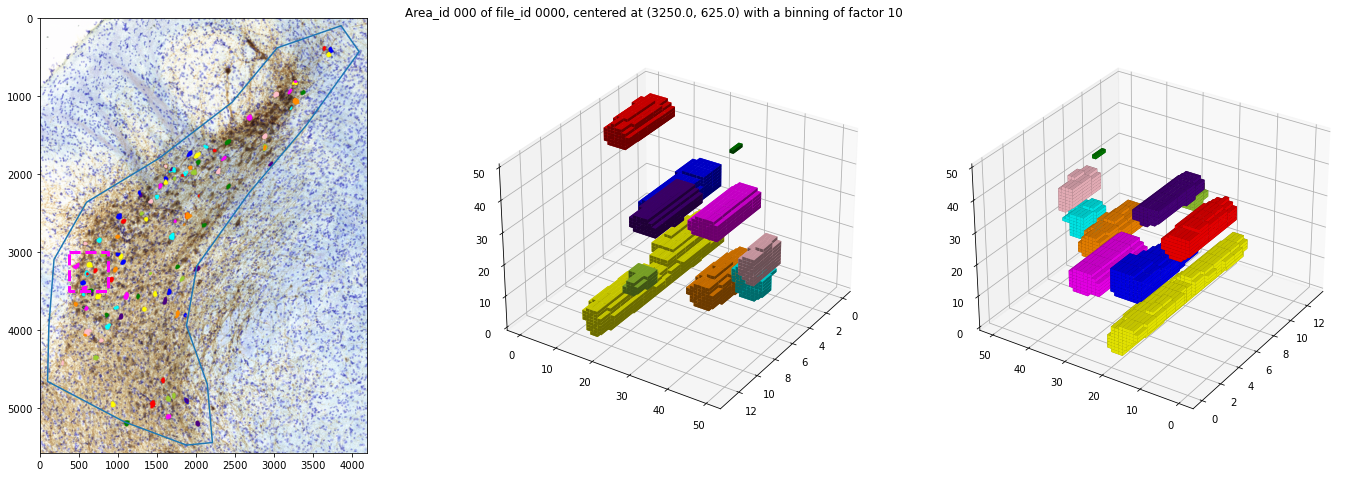

In [75]:
inspect_in_3d(file_id = '0000', area_id = '000', center_pixel_coords = (3250, 625), half_box_size = 250, binning_factor = 10, save = True, show = True)

## Plotting 3D labels in 2D for whole-image-inspection: (code from previous developments)

Grouping of three images, all of which have the area ROI outlined:
- the preprocessed image
- the instance segmentation mask (rgb-colored)
- overlay of both images

Requires - among other things - a findmycells project 

In [ ]:
for file_id in file_infos['file_id']:
    look_up_index = file_infos['file_id'].index(file_id)
    if file_infos['total_planes'][look_up_index] > 1:
        image_zstack = load_zstack_as_array_from_single_planes(path = th_in_sn.database.preprocessed_images_dir, file_id = file_id)
        image = np.max(image_zstack, axis=0)
        # make generic for roi_id (and check for "all planes"?
        quantified_mask_zstack = load_zstack_as_array_from_single_planes(path = th_in_sn.database.quantified_segmentations_dir.joinpath('000'), file_id = file_id)
        quantified_mask = np.max(quantified_mask_zstack, axis=0)
    else:    
        image = imread(th_in_sn.database.preprocessed_images_dir.joinpath(f'{file_id}-000.png'))
        quantified_mask = imread(th_in_sn.database.quantified_segmentations_dir.joinpath('000', f'{file_id}-000_postprocessed_segmentations.png'))
    rgb_mask = label2rgb(quantified_mask)
    overlay = label2rgb(quantified_mask, image=image, bg_label = 0, bg_color = None, saturation=1, alpha=1)
    roi_coords = th_in_sn.database.area_rois_for_quantification[file_id]['all_planes']['000'].boundary.coords.xy
    original_file_id = file_infos['original_file_id'][look_up_index]
    group_id = file_infos['group_id'][look_up_index]
    features_per_square_reference_space = df.loc[df['file_id'] == file_id, 'cc3D_per_mm^3'].iloc[0].round(2)
    total_features = df.loc[df['file_id'] == file_id, 'connected_components_3D'].iloc[0]
    title = f'{group_id} - {original_file_id}: {features_per_square_reference_space} features per mm^3 ({total_features} total features detected)'


    fig = plt.figure(figsize=(24,12), facecolor='white')
    gs = fig.add_gridspec(1,3)

    fig.add_subplot(gs[0,0])
    plt.imshow(image)
    plt.plot(roi_coords[1], roi_coords[0])

    fig.add_subplot(gs[0,1])
    plt.imshow(rgb_mask)
    plt.plot(roi_coords[1], roi_coords[0])

    fig.add_subplot(gs[0,2])
    plt.imshow(overlay)
    plt.plot(roi_coords[1], roi_coords[0])

    plt.suptitle(title, y=0.9)
    plt.savefig(th_in_sn.database.inspection_dir.joinpath(f'{file_id}_inspection.png'), dpi=150)
    plt.close()
    
    print(f'Done with {file_id}')